In [252]:
from itertools import product # combinatorics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as ss # statistical functions
import matplotlib.pyplot as plt # plotting
import seaborn as sns # pretty plots
import math # math functions
import warnings # clear warnings

from collections import Counter
from sklearn.model_selection import train_test_split # data splitting

import tensorflow as tf  # building NN model
from tensorflow.keras.layers.experimental import preprocessing # input preprocessing
from sklearn.preprocessing import StandardScaler
# model evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score, f1_score,confusion_matrix

warnings.filterwarnings('ignore')

### Reading the files

#### USPs

In [253]:
# Reading the usp text file as a csv file with the delimiter \t(tab) 
usp_data = pd.read_csv('data/usp.txt', delimiter='\t', header=None)
# Renaming the column and adding a new column as a label
usp_data.rename(columns={0:'sequence'}, inplace=True)
usp_data['label'] = 'usp'
usp_data.head()

,sequence,label
0,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp
1,MTIVVGYLAGKVGPSALHLAVRVARMHKTSLTVATIVRRHWPTPSL...,usp
2,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp
3,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp
4,MSSGNSSLGIIVGIDDSPAAQVAVRWAARDAELRKIPLTLVHAVSP...,usp


#### Non-USPs

In [254]:
# Reading the usp text file as a csv file with the delimiter \t(tab) 
non_usp_data = pd.read_csv('data/non_usp.txt', delimiter='\t', header=None)
# Renaming the column and adding a new column as a label
non_usp_data.rename(columns={0:'sequence'}, inplace=True)
non_usp_data['label'] = 'non_usp'
non_usp_data.head()

,sequence,label
0,MSTTEFPTTTKRLMGWGRTAPTVASVLSTSDPEVIVRAVTRAAEEG...,non_usp
1,MAISGVPVLGFFIIAVLMSAQESWAIKEEHVIIQAEFYLNPDQSGE...,non_usp
2,MVCLKLPGGSCMTALTVTLMVLSSPLALSGDTRPRFLWQPKRECHF...,non_usp
3,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,non_usp
4,MPELPEVETSRRGIEPHLVGATILHAVVRNGRLRWPVSEEIYRLSD...,non_usp


### Merging the two data together vertically

In [255]:
df = pd.concat([usp_data, non_usp_data], ignore_index=True)
df.sample(5)

,sequence,label
53,MNQSHKPPSIVVGIDGSKPAVQAALWAVDEAASRDIPLRLLYAIEP...,usp
329,MSVTPDITITLQNRFASELPEMAVPWHAEVPPEARLLVLNEPLADE...,non_usp
553,MTYVIGEPCVDVMDRACVEECPVDCIYEGGRALYIHPDECVDCGAC...,non_usp
519,MATHDVDAVILVGGKGTRLRPLTLSAPKPMLPTAGLPFLTHLLSRI...,non_usp
326,MAQKDVLTDLTKVRNIGIMAHIDAGKTTTTERILYYTGISYKIGEV...,non_usp


In [256]:
df['sequence'][0]

'MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPPVITAPEGWAFEYSRFQEAQKREIVEHSYLVAQAHQIVEQAHKVALEASSSGRAAQITGEVLHGQIVPTLTNISRQVAMVVLGYRGQGAVAGALLGSVSSSLVRHAHGPVAVIPEEPRPARPPHAPVVVGIDGSPTSGLAAEIAFDEASRRGVDLVALHAWSDMGPLDFPRLNWAPIEWRNLEDEQEKMLARRLSGWQDRYPDVVVHKVVVCDRPAPRLLELAQTAQLVVVGSHGRGGFPGMHLGSVSRAVVNSGQAPVIVARIPQDPAVPA'

#### Checking the uniqueness of the sequence

In [257]:
alpha = np.unique(list(df['sequence'][0]))
alpha

array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype='<U1')

In [258]:
df['sequence'][0].count('A')/len(df['sequence'][0])

0.12618296529968454

#### Converting the label from usp and non_usp into 1 and 0

In [259]:
df['target'] = df['label'].apply(lambda x: 1 if x == 'usp' else 0)

In [260]:
df['target'].unique()

array([1, 0], dtype=int64)

#### Creating a column for each of the alphabets

In [261]:
for letter in alpha:
    df[letter] = 0

In [262]:
df.head()

,sequence,label,target,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
0,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MTIVVGYLAGKVGPSALHLAVRVARMHKTSLTVATIVRRHWPTPSL...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MSSGNSSLGIIVGIDDSPAAQVAVRWAARDAELRKIPLTLVHAVSP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Creating a column each for the di- alphabets
    using product from itertools
    and merging with the mono alphabets

In [263]:
# This was hardcoded to remove unnecesary characters
# that might make it hard to access each column
combos = product(alpha, repeat=2)
for combo in combos:
    df[str(combo).replace(',', '').replace("'",'').replace(' ', '').replace(')', '').replace('(', '')] = 0

In [264]:
df

,sequence,label,target,A,C,D,E,F,G,H,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MTIVVGYLAGKVGPSALHLAVRVARMHKTSLTVATIVRRHWPTPSL...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MSSGNSSLGIIVGIDDSPAAQVAVRWAARDAELRKIPLTLVHAVSP...,usp,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,MTRAGDDAVNLTLVTGAPANGGSCVAHHEGRVVFVRYALPGERVRA...,non_usp,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
655,MGAQGYLRRLTRRLTEDLEQRDVEELSDEVLNAGAQRAIDCQRGQE...,non_usp,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
656,MFESLSDRLTAALQGLRGKGRLTDADIDATTREIRLALLEADVSLP...,non_usp,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
657,MTEALIPAPSQISLTRDEVRRYSRHLIIPDIGVNGQQRLKDARVLC...,non_usp,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [265]:
non_alpha = ['sequence', 'label','target']
columns = df.columns
columns = [column for column in columns if column not in non_alpha]
len(columns)

420

### Calculating the values to be inserted in the mono alphabets and di alphabets
    creating a function for calculating the value

In [266]:
for column in columns:
    df[column] = df['sequence'].apply(lambda x: x.count(column)/len(x))


In [267]:
df.head()

,sequence,label,target,A,C,D,E,F,G,H,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0.126183,0.006309,0.037855,0.056782,0.015773,0.082019,0.037855,...,0.0,0.0,0.003155,0.0,0.003155,0.003155,0.000000,0.0,0.0,0.0
1,MTIVVGYLAGKVGPSALHLAVRVARMHKTSLTVATIVRRHWPTPSL...,usp,1,0.116438,0.010274,0.037671,0.054795,0.013699,0.078767,0.030822,...,0.0,0.0,0.003425,0.0,0.003425,0.006849,0.003425,0.0,0.0,0.0
2,MSAQQTNLGIVVGVDGSPCSHTAVEWAARDAQMRNVALRVVQVVPP...,usp,1,0.129338,0.006309,0.037855,0.056782,0.015773,0.082019,0.037855,...,0.0,0.0,0.003155,0.0,0.003155,0.003155,0.000000,0.0,0.0,0.0
3,MSKPRKQHGVVVGVDGSLESDAAACWGATDAAMRNIPLTVVHVVNA...,usp,1,0.125424,0.010169,0.050847,0.061017,0.010169,0.081356,0.023729,...,0.0,0.0,0.006780,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,MSSGNSSLGIIVGIDDSPAAQVAVRWAARDAELRKIPLTLVHAVSP...,usp,1,0.117845,0.006734,0.057239,0.053872,0.003367,0.077441,0.030303,...,0.0,0.0,0.003367,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [268]:
df.columns = df.columns.astype(str)

### Doing some analyses
    - correlation of the variables
    - relationship of the variables with the outcome/label

In [269]:
label = df.pop('label')
target = df.pop('target')

In [270]:
text = df.pop('sequence')

In [271]:
mono_col = alpha
di_col = [col for col in df.columns if col not in mono_col]

In [272]:
# analysis of mono_alpha(singular alphabets) features
numerical_data = df[mono_col]
# summary statistics for numerical features
numerical_data.describe()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,0.110534,0.010132,0.061132,0.057090,0.026298,0.089055,0.021917,0.045576,0.038916,0.084770,0.020162,0.024205,0.057840,0.032159,0.076566,0.055450,0.056322,0.095586,0.012344,0.021276
std,0.037156,0.014086,0.024070,0.023890,0.016228,0.026520,0.013094,0.017981,0.030904,0.028895,0.009195,0.012646,0.022718,0.015355,0.030447,0.020467,0.020771,0.028093,0.012107,0.012416
min,0.026549,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.086896,0.000000,0.045455,0.040816,0.015000,0.074830,0.013605,0.034139,0.017544,0.065615,0.014265,0.015802,0.044248,0.021894,0.057524,0.041625,0.043573,0.076059,0.004525,0.012618
50%,0.108844,0.006211,0.061224,0.054645,0.025000,0.085973,0.020665,0.043103,0.029412,0.083333,0.019048,0.023762,0.055130,0.030303,0.072555,0.054945,0.054745,0.095238,0.010949,0.020704
75%,0.128802,0.012766,0.072858,0.069884,0.034952,0.101554,0.029240,0.055970,0.053126,0.102115,0.025573,0.031674,0.066909,0.040000,0.091874,0.068790,0.068467,0.110000,0.017544,0.028026
max,0.309278,0.081633,0.181818,0.181818,0.100000,0.222222,0.097087,0.117647,0.203540,0.216667,0.066667,0.081633,0.147887,0.093750,0.222222,0.148872,0.132530,0.217391,0.181818,0.090909


In [273]:
numerical_data2 = df[di_col]
numerical_data2.describe()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,...,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,0.013059,0.000825,0.006688,0.006689,0.002293,0.009859,0.002452,0.004738,0.005211,0.009336,...,0.000121,0.000408,0.001453,0.000561,0.001870,0.000922,0.001486,0.001692,0.000227,0.000624
std,0.011530,0.002735,0.006822,0.006114,0.003352,0.007860,0.003836,0.005275,0.007733,0.007899,...,0.000612,0.001481,0.002390,0.001525,0.003148,0.002125,0.003664,0.002968,0.000982,0.001756
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006552,0.000000,0.000000,0.001876,0.000000,0.003401,0.000000,0.000000,0.000000,0.003401,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011111,0.000000,0.005618,0.005714,0.000000,0.009346,0.000000,0.003843,0.003546,0.008547,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.017012,0.000000,0.010174,0.010169,0.003731,0.014035,0.003425,0.007356,0.006842,0.013875,...,0.000000,0.000000,0.002729,0.000000,0.003048,0.000000,0.000917,0.002829,0.000000,0.000000
max,0.103093,0.020408,0.050000,0.033333,0.030928,0.045714,0.027778,0.048387,0.066372,0.051852,...,0.007782,0.016667,0.014815,0.014599,0.017751,0.014925,0.037037,0.018182,0.008772,0.016667


In [274]:
columns = ['A','C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 'AA',
 'AC',
 'AD',
 'AE',
 'AF',
 'AG',
 'AH',
 'AI',
 'AK',
 'AL',
 'AM',
 'AN',
 'AP',
 'AQ',
 'AR',
 'AS',
 'AT',
 'AV',
 'AW',
 'AY',
 'CA',
 'CC',
 'CD',
 'CE',
 'CF',
 'CG',
 'CH',
 'CI',
 'CK',
 'CL',
 'CM',
 'CN',
 'CP',
 'CQ',
 'CR',
 'CS',
 'CT',
 'CV',
 'CW',
 'CY',
 'DA',
 'DC',
 'DD',
 'DE',
 'DF',
 'DG',
 'DH',
 'DI',
 'DK',
 'DL',
 'DM',
 'DN',
 'DP',
 'DQ',
 'DR',
 'DS',
 'DT',
 'DV',
 'DW',
 'DY',
 'EA',
 'EC',
 'ED',
 'EE',
 'EF',
 'EG',
 'EH',
 'EI',
 'EK',
 'EL',
 'EM',
 'EN',
 'EP',
 'EQ',
 'ER',
 'ES',
 'ET',
 'EV',
 'EW',
 'EY',
 'FA',
 'FC',
 'FD',
 'FE',
 'FF',
 'FG',
 'FH',
 'FI',
 'FK',
 'FL',
 'FM',
 'FN',
 'FP',
 'FQ',
 'FR',
 'FS',
 'FT',
 'FV',
 'FW',
 'FY',
 'GA',
 'GC',
 'GD',
 'GE',
 'GF',
 'GG',
 'GH',
 'GI',
 'GK',
 'GL',
 'GM',
 'GN',
 'GP',
 'GQ',
 'GR',
 'GS',
 'GT',
 'GV',
 'GW',
 'GY',
 'HA',
 'HC',
 'HD',
 'HE',
 'HF',
 'HG',
 'HH',
 'HI',
 'HK',
 'HL',
 'HM',
 'HN',
 'HP',
 'HQ',
 'HR',
 'HS',
 'HT',
 'HV',
 'HW',
 'HY',
 'IA',
 'IC',
 'ID',
 'IE',
 'IF',
 'IG',
 'IH',
 'II',
 'IK',
 'IL',
 'IM',
 'IN',
 'IP',
 'IQ',
 'IR',
 'IS',
 'IT',
 'IV',
 'IW',
 'IY',
 'KA',
 'KC',
 'KD',
 'KE',
 'KF',
 'KG',
 'KH',
 'KI',
 'KK',
 'KL',
 'KM',
 'KN',
 'KP',
 'KQ',
 'KR',
 'KS',
 'KT',
 'KV',
 'KW',
 'KY',
 'LA',
 'LC',
 'LD',
 'LE',
 'LF',
 'LG',
 'LH',
 'LI',
 'LK',
 'LL',
 'LM',
 'LN',
 'LP',
 'LQ',
 'LR',
 'LS',
 'LT',
 'LV',
 'LW',
 'LY',
 'MA',
 'MC',
 'MD',
 'ME',
 'MF',
 'MG',
 'MH',
 'MI',
 'MK',
 'ML',
 'MM',
 'MN',
 'MP',
 'MQ',
 'MR',
 'MS',
 'MT',
 'MV',
 'MW',
 'MY',
 'NA',
 'NC',
 'ND',
 'NE',
 'NF',
 'NG',
 'NH',
 'NI',
 'NK',
 'NL',
 'NM',
 'NN',
 'NP',
 'NQ',
 'NR',
 'NS',
 'NT',
 'NV',
 'NW',
 'NY',
 'PA',
 'PC',
 'PD',
 'PE',
 'PF',
 'PG',
 'PH',
 'PI',
 'PK',
 'PL',
 'PM',
 'PN',
 'PP',
 'PQ',
 'PR',
 'PS',
 'PT',
 'PV',
 'PW',
 'PY',
 'QA',
 'QC',
 'QD',
 'QE',
 'QF',
 'QG',
 'QH',
 'QI',
 'QK',
 'QL',
 'QM',
 'QN',
 'QP',
 'QQ',
 'QR',
 'QS',
 'QT',
 'QV',
 'QW',
 'QY',
 'RA',
 'RC',
 'RD',
 'RE',
 'RF',
 'RG',
 'RH',
 'RI',
 'RK',
 'RL',
 'RM',
 'RN',
 'RP',
 'RQ',
 'RR',
 'RS',
 'RT',
 'RV',
 'RW',
 'RY',
 'SA',
 'SC',
 'SD',
 'SE',
 'SF',
 'SG',
 'SH',
 'SI',
 'SK',
 'SL',
 'SM',
 'SN',
 'SP',
 'SQ',
 'SR',
 'SS',
 'ST',
 'SV',
 'SW',
 'SY',
 'TA',
 'TC',
 'TD',
 'TE',
 'TF',
 'TG',
 'TH',
 'TI',
 'TK',
 'TL',
 'TM',
 'TN',
 'TP',
 'TQ',
 'TR',
 'TS',
 'TT',
 'TV',
 'TW',
 'TY',
 'VA',
 'VC',
 'VD',
 'VE',
 'VF',
 'VG',
 'VH',
 'VI',
 'VK',
 'VL',
 'VM',
 'VN',
 'VP',
 'VQ',
 'VR',
 'VS',
 'VT',
 'VV',
 'VW',
 'VY',
 'WA',
 'WC',
 'WD',
 'WE',
 'WF',
 'WG',
 'WH',
 'WI',
 'WK',
 'WL',
 'WM',
 'WN',
 'WP',
 'WQ',
 'WR',
 'WS',
 'WT',
 'WV',
 'WW',
 'WY',
 'YA',
 'YC',
 'YD',
 'YE',
 'YF',
 'YG',
 'YH',
 'YI',
 'YK',
 'YL',
 'YM',
 'YN',
 'YP',
 'YQ',
 'YR',
 'YS',
 'YT',
 'YV',
 'YW',
 'YY']

df = df[columns]

In [275]:
target

0      1
1      1
2      1
3      1
4      1
      ..
654    0
655    0
656    0
657    0
658    0
Name: target, Length: 659, dtype: int64

In [276]:
ssc = StandardScaler()
ssc.fit(df[columns])
df[columns] = ssc.transform(df[columns])
print('fitted_training features:')
df

fitted_training features:


,A,C,D,E,F,G,H,I,K,L,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,0.421499,-0.271597,-0.967806,-0.012877,-0.649037,-0.265511,1.218124,-0.254139,-0.851595,-0.423056,...,-0.197597,-0.275688,0.712295,-0.368062,0.408371,1.051874,-0.405890,-0.570599,-0.231843,-0.355262
1,0.159038,0.010081,-0.975442,-0.096146,-0.776951,-0.388221,0.680602,-0.630548,-0.816611,0.859587,...,-0.197597,-0.275688,0.825372,-0.368062,0.494232,2.792273,0.529453,-0.570599,-0.231843,-0.355262
2,0.506464,-0.271597,-0.967806,-0.012877,-0.649037,-0.265511,1.218124,-0.254139,-0.851595,-0.423056,...,-0.197597,-0.275688,0.712295,-0.368062,0.408371,1.051874,-0.405890,-0.570599,-0.231843,-0.355262
3,0.401050,0.002658,-0.427612,0.164511,-0.994584,-0.290530,0.138485,-1.027274,-0.382036,-0.118248,...,-0.197597,-0.275688,2.230021,-0.368062,-0.594488,-0.434080,-0.405890,-0.570599,-0.231843,-0.355262
4,0.196928,-0.241414,-0.161867,-0.134788,-1.414077,-0.438261,0.640944,-0.287836,-0.933112,0.329233,...,-0.197597,-0.275688,0.801233,-0.368062,-0.594488,-0.434080,-0.405890,-0.570599,-0.231843,-0.355262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,0.946604,0.683517,0.230106,-0.529709,-0.251321,0.645960,0.966903,-1.299799,-0.940380,-0.028383,...,-0.197597,-0.275688,-0.608440,-0.368062,0.190466,0.729000,-0.405890,1.094507,2.285484,-0.355262
655,-1.652485,0.444834,-0.156130,1.042115,-1.116240,1.588404,-1.048614,-0.255578,-0.463915,0.754588,...,-0.197597,5.264784,-0.608440,-0.368062,-0.594488,-0.434080,-0.405890,-0.570599,-0.231843,-0.355262
656,0.421824,-0.040627,0.002213,0.091475,0.500691,0.824293,-0.944403,0.123873,0.659220,0.573833,...,-0.197597,-0.275688,-0.608440,-0.368062,-0.594488,-0.434080,-0.405890,-0.570599,-0.231843,-0.355262
657,-0.415265,1.106505,0.237231,-0.345446,-0.670541,0.034692,0.486146,2.184986,-0.344505,0.714449,...,-0.197597,-0.275688,-0.608440,-0.368062,1.857232,0.776839,-0.405890,0.296198,-0.231843,-0.355262


In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Columns: 420 entries, A to YY
dtypes: float64(420)
memory usage: 2.1 MB


#### Getting the correlation between the singular group/mono_alphabets part of the sequence
    - This helps is selecting the useful features from the huge columns we have
    

    MONO-ALPHABETS

In [278]:
# calculate point biserial coefficient between numerical(mono alphabets) features and the target variable

rpb_scores_mono = dict()

for feature in mono_col:
    y = numerical_data[feature]
    rpb = abs(ss.stats.pointbiserialr(y,target).correlation)
    rpb_scores_mono[feature] = rpb
    
# sort the scores in descending order
rpb_scores_mono = sorted(rpb_scores_mono.items(),key=lambda kv: (kv[1],kv[0]),reverse=True)
for k,v in rpb_scores_mono:
    print("{} : {}".format(k,v))

V : 0.35299030551311283
T : 0.3299375467231308
F : 0.32745303260376796
S : 0.2889068321801659
H : 0.25634977598141373
A : 0.23471509838546756
N : 0.18433356353331845
K : 0.16935214723401792
Y : 0.14978221912190992
D : 0.10718609705976613
W : 0.10396009061591244
G : 0.10023183419824688
M : 0.09478474078228466
I : 0.07974936940093644
Q : 0.06923718831419089
R : 0.020599411718022063
L : 0.014582889830924253
E : 0.014452939947387734
C : 0.014086731140724578
P : 0.003811848744872783


### Plotting the graph of the top 20 mono features with the highest correlation to the target variable

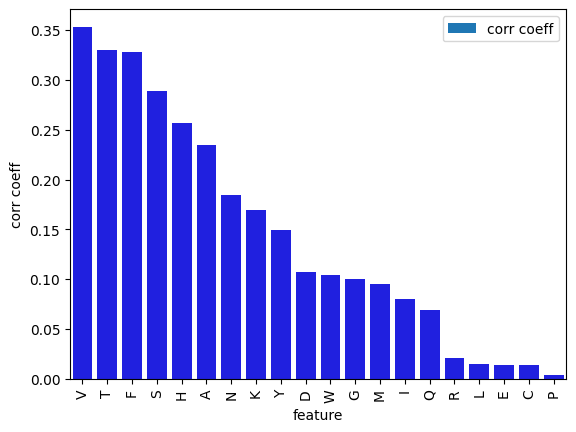

In [279]:
data_mono = pd.DataFrame(rpb_scores_mono, columns=['feature', 'corr coeff'])
data_mono[0:20].plot(kind='bar')
sns.barplot(data = data_mono[0:20], x='feature', y='corr coeff', color='blue')
# plt.xlabel(data['feature'][0:20])
plt.savefig('mono_alpha.jpg')

    BI-ALPHABETS

In [280]:
# calculate point biserial coefficient between numerical(bi alphabets) features and the target variable

rpb_scores_bi = dict()

for feature in di_col:
    y = numerical_data2[feature]
    rpb = abs(ss.stats.pointbiserialr(y,target).correlation)
    rpb_scores_bi[feature] = rpb
    
# sort the scores in descending order
rpb_scores_bi = sorted(rpb_scores_bi.items(),key=lambda kv: (kv[1],kv[0]),reverse=True)
for k,v in rpb_scores_bi:
    print("{} : {}".format(k,v))

GS : 0.4988210855522441
WQ : 0.4218265057336953
HA : 0.38376443590503734
PV : 0.36609603482338454
VG : 0.3644740968721593
VV : 0.31266576490790193
VH : 0.2874920496450957
MS : 0.27866497852743
LV : 0.2782363080391816
WP : 0.27814213289076345
WA : 0.276294332780257
AV : 0.27621776688399746
EA : 0.2759735037018608
YP : 0.26853122290553705
LH : 0.26530128124355196
GD : 0.2513567764669557
SA : 0.24270063135641756
SH : 0.2400620120120587
AH : 0.23259859377165476
AQ : 0.23123083307849407
SV : 0.22658946209138986
SR : 0.21182718178241522
GW : 0.21071346452924475
RT : 0.20871750243544282
DT : 0.20828221544224423
QQ : 0.20517882458069922
IV : 0.20395686855267783
VT : 0.2020830720464976
SS : 0.20158997226345002
FG : 0.19422169718008278
HS : 0.19346498153970643
LA : 0.18937225578524663
EG : 0.18742367988981737
FA : 0.18623936430392835
AS : 0.17999177730330854
AR : 0.1796955789352605
NP : 0.1790272383405273
IR : 0.17881899696470746
TR : 0.17689940085458472
GK : 0.17598906108110315
RI : 0.169426293

#### Plotting the top 20 values of the bi alphabets with the highest correlation to the target variable

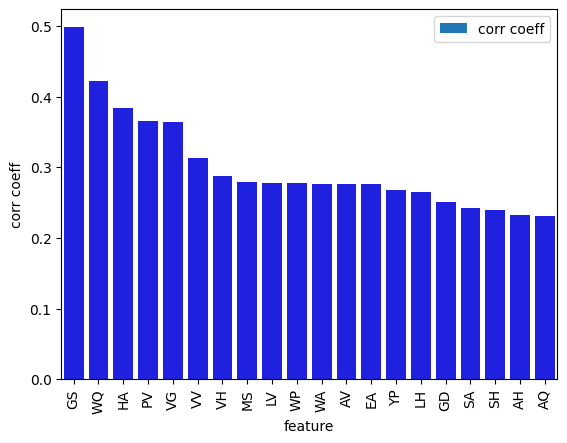

In [281]:
data_bi = pd.DataFrame(rpb_scores_bi, columns=['feature', 'corr coeff'])
data_bi[0:20].plot(kind='bar')
sns.barplot(data = data_bi[0:20], x='feature', y='corr coeff', color='blue')
plt.savefig('bi-alpha_corr.jpg')

### Building the model

    splitting the dataset into:
        train - 60
        val - 20
        test - 20

In [282]:
# splitting the data into train,test and validation
X_train, x_test, Y_train, y_test = train_test_split(df, target, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25)
print(len(x_train), 'train examples')
print(len(x_val), 'validation examples')
print(len(x_test), 'test examples')



370 train examples
124 validation examples
165 test examples


### Using the Support vector machine

In [283]:
from sklearn.svm import SVC

model_svc = SVC()

model_svc.fit(x_train, y_train)

SVC()

In [284]:
y_pred_svc = model_svc.predict(x_test)
y_pred_svc

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [285]:
print("accuracy:\n  {}".format(accuracy_score(y_pred_svc,y_test)))
print("\n")
print("classification report:\n {}".format(classification_report(y_pred_svc,y_test)))

accuracy:
  0.9878787878787879


classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.86      1.00      0.92        12

    accuracy                           0.99       165
   macro avg       0.93      0.99      0.96       165
weighted avg       0.99      0.99      0.99       165



    An accuracy of 98.18% is acheived with the svm model 

confusion matrix: 
[[151   2]
 [  0  12]]


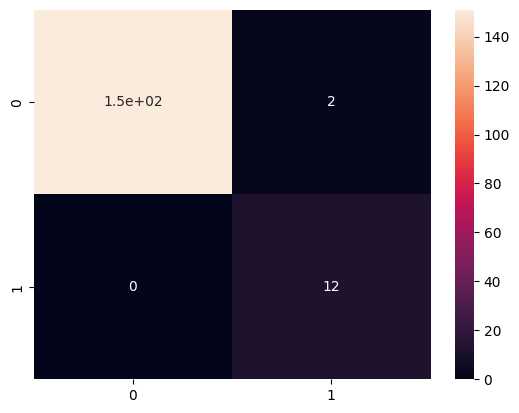

<Figure size 640x480 with 0 Axes>

In [286]:
print("confusion matrix: ")
print(confusion_matrix(y_pred_svc,y_test))
cm = confusion_matrix(y_pred_svc,y_test)
sns.heatmap(cm,annot=True)
plt.show()
plt.savefig('svm_confusion_matrix_heatmap.jpg')

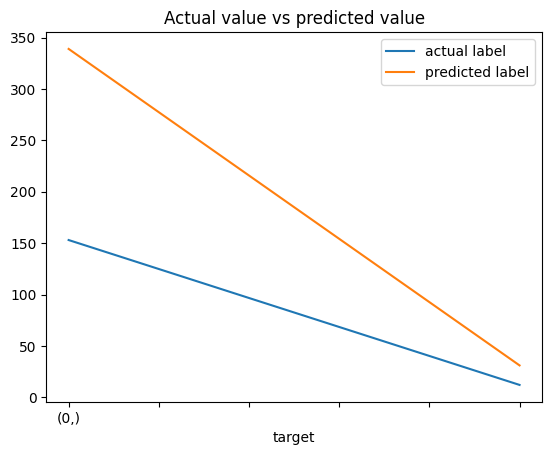

In [287]:
y_pred_svc = pd.DataFrame(y_pred_svc)
y_pred_svc.value_counts().plot(label='actual label')
pd.DataFrame(y_train).value_counts().plot(label='predicted label', title = 'Actual value vs predicted value')
plt.legend()
plt.savefig('rf_comparison.jpg')

#### Using K-Fold
        Stratified K-Fold 

In [288]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
skfold=StratifiedKFold(n_splits=5)
model=RandomForestClassifier()
scores=cross_val_score(model_rf,x_test,y_test,cv=skfold)
print('scores: ',scores)
print('Average/ Mean score: ', np.mean(scores))

scores:  [0.96969697 0.96969697 0.96969697 1.         0.96969697]
Average/ Mean score:  0.9757575757575758


#### Plotting the ROC curve

In [289]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc)

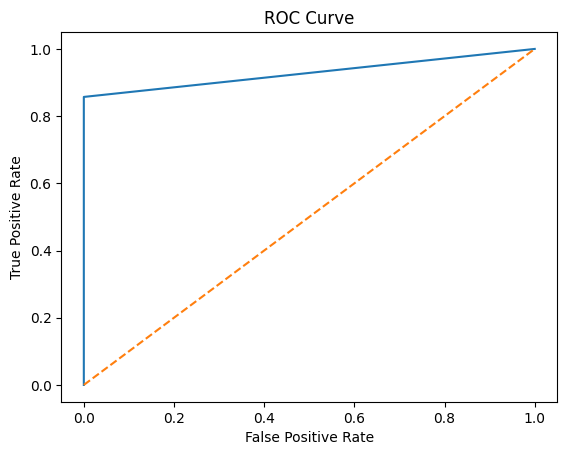

<Figure size 640x480 with 0 Axes>

In [290]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
plt.savefig('svm_roc.jpg')

In [291]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()

model_rf.fit(x_train, y_train)

RandomForestClassifier()

In [292]:
y_pred_rf = model_rf.predict(x_test)
y_pred_rf

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [293]:
print("accuracy:\n  {}".format(accuracy_score(y_pred_rf,y_test)))
print("\n")
print("classification report:\n {}".format(classification_report(y_pred_rf,y_test)))

accuracy:
  0.9878787878787879


classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.86      1.00      0.92        12

    accuracy                           0.99       165
   macro avg       0.93      0.99      0.96       165
weighted avg       0.99      0.99      0.99       165



    An accuracy of 97.57% is acheived with the RandomForest model

confusion matrix: 
[[151   2]
 [  0  12]]


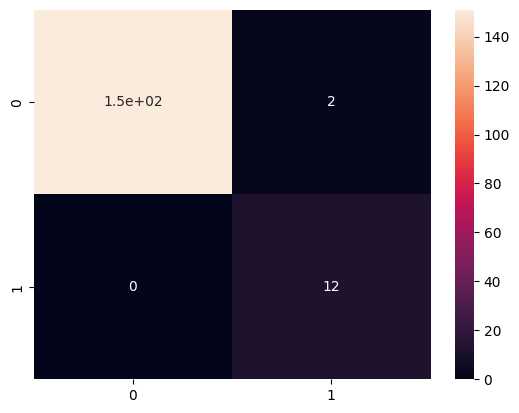

<Figure size 640x480 with 0 Axes>

In [294]:
print("confusion matrix: ")
print(confusion_matrix(y_pred_rf,y_test))
cm = confusion_matrix(y_pred_rf,y_test)
sns.heatmap(cm,annot=True)
plt.show()
plt.savefig('random_forest_confusion_matrix_heatmap.jpg')

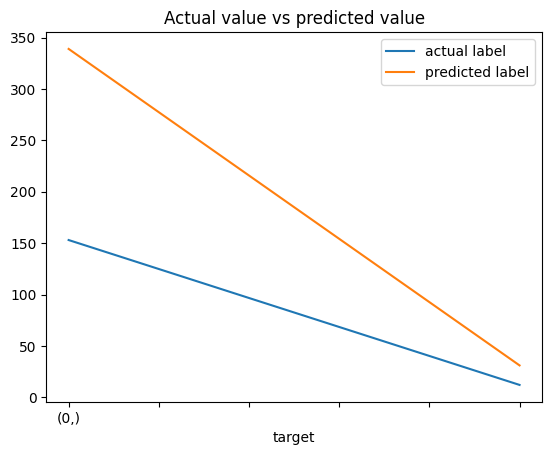

In [295]:
y_pred_svc = pd.DataFrame(y_pred_svc)
y_pred_svc.value_counts().plot(label='actual label')
pd.DataFrame(y_train).value_counts().plot(label='predicted label', title = 'Actual value vs predicted value')
plt.legend()
plt.savefig('svc_comparison.jpg')

#### Using K-Fold Cross Validation

In [296]:
from sklearn.model_selection import KFold
model=SVC()
kfold_validation=KFold(10)
from sklearn.model_selection import cross_val_score
results=cross_val_score(model_svc,x_test,y_test,cv=kfold_validation)
print('Scores: ',results)
print('Average score: ', np.mean(results))

Scores:  [0.88235294 0.94117647 1.         1.         1.         1.
 1.         0.9375     1.         0.9375    ]
Average score:  0.9698529411764707


#### Plotting the ROC curve

In [297]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

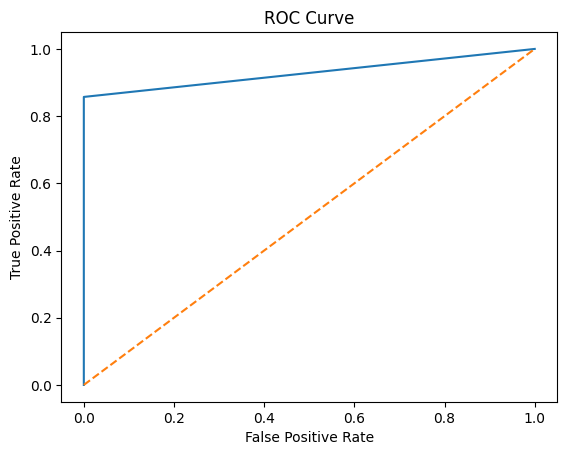

<Figure size 640x480 with 0 Axes>

In [298]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
plt.savefig('random_forest_roc.jpg')